In [37]:
START=300;
END=375;

### Goal: Try again on estimation on region
Based on all the features we get this time.

In [16]:
import tensorflow as tf;
import numpy as np;
import matplotlib.pyplot as plt;
print(tf.__version__);
import pandas as pd;

from sklearn.preprocessing import StandardScaler;
from sklearn.preprocessing import MinMaxScaler;
from sklearn.metrics import mean_squared_error;

import datetime;

2.6.0


In [17]:
pd.set_option('display.max_columns', 300);
pd.set_option('display.max_rows', 300);
tf.keras.backend.set_floatx('float64');

In [18]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

['/device:GPU:0']

In [19]:
MONTHS = 60;
SPLIT = 48; # 2015-2018: training, 2019: testing.
# BATCH_SIZE = 19; # used in NN_v1
BATCH_SIZE = 24;
WINDOW_SIZE = 3;

TEST_LENGTH = MONTHS - SPLIT;

### Data preparation

In [20]:
multi_data = pd.read_csv('../data/full_dataset_engineered.csv', index_col=0);
zip_ids = multi_data.index.unique();

multi_data.drop(["City", "State", "Metro", "CountyName", "year", "month", "year-month"],\
                 axis = 1, inplace = True);

multi_data.head()

,zri,total_pop,percent_rental_units_occupied,percent_highschool,percent_work_from_home,percent_buildings_50+_units,median_building_age,median_age,income_per_capita,percent_native_am,percent_buildings_10_19_units,poverty_rate,percent_white,percent_commute_public_transport,percent_associates,percent_units_owner_occupied,percent_workforce_unemployed,percent_buildings_20_49_units,bs_total_stations,trader joe's,flood,gun_searches,pronouns,twitter,lululemon,retirement,same sex marriage,hurricane,political correctness,job opportunities,unemployment,layoff,wildfire,hashtag,fake news,multifamily_for_rent_searches,thrift,make america great again,flight tickets,black lives matter,lgbt,whole foods,fire,apartment_for_rent_searches,places to go,starbucks,getaway,euthanasia,net_job_rate,startup_firms,state_local_perc
zip,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1013,946.0,21846.25,0.942265,0.383459,0.014618,0.049514,62.333333,36.508333,20935.75,0.000113,0.030202,0.199214,0.714892,0.022609,0.257328,0.423344,0.105077,0.036863,0.0,-0.662346,0.944722,-3.278835,-1.326593,1.004233,-0.212701,-1.425905,-0.588436,-0.285509,0.0,0.096863,3.466751,-0.823717,-0.443099,0.448996,-0.659443,-0.259098,-0.377642,-0.514772,-1.378408,-0.509999,-0.141562,0.291193,1.162014,-4.544528,-1.304734,-1.712329,-0.468627,-0.150792,1.993000,383.0,0.176793
1013,950.0,21870.50,0.942497,0.385186,0.014466,0.049557,62.666667,36.416667,20931.50,0.000226,0.030477,0.196885,0.715367,0.023198,0.255708,0.421607,0.105835,0.036368,0.0,0.435704,-1.199445,1.929184,-1.326593,1.303017,0.157345,-1.217118,-0.588436,-0.431227,0.0,1.061035,1.934232,-0.823717,-0.443099,0.448996,-0.659443,-0.765415,-0.826044,-0.514772,-0.847070,-0.509999,-1.071717,0.719432,0.225152,-0.351858,-0.015282,-1.241616,0.019798,-0.150792,1.750833,382.0,0.176313
1013,958.0,21894.75,0.942730,0.386912,0.014314,0.049601,63.000000,36.325000,20927.25,0.000339,0.030752,0.194555,0.715842,0.023787,0.254088,0.419870,0.106592,0.035873,0.0,-0.662346,-0.127361,0.951713,0.732224,1.751194,-0.952793,0.348785,-0.086484,-0.285509,0.0,-0.385223,0.991144,-0.823717,-0.443099,0.448996,0.570434,-0.336470,-0.527109,-0.514772,-0.847070,-0.509999,-1.536795,0.230016,1.295851,-2.620528,-1.304734,-1.268533,-0.794244,1.382217,1.508667,381.0,0.175832
1013,958.0,21919.00,0.942962,0.388639,0.014162,0.049644,63.333333,36.233333,20923.00,0.000452,0.031027,0.192226,0.716318,0.024375,0.252468,0.418133,0.107350,0.035378,0.0,1.533754,-0.127361,-0.167832,-1.326593,2.348763,-0.582747,-0.799544,-0.588436,-0.358368,0.0,-1.349394,1.462688,-0.823717,-0.443099,0.448996,-0.659443,-0.765415,-0.377642,-0.514772,-0.847070,-0.509999,-1.071717,1.086494,0.760502,-2.839611,-1.820515,-0.743268,-1.282668,-0.150792,1.266500,380.0,0.175352
1013,955.0,21943.25,0.943195,0.390365,0.014010,0.049687,63.666667,36.141667,20918.75,0.000565,0.031302,0.189897,0.716793,0.024964,0.250848,0.416396,0.108107,0.034883,0.0,-0.296329,0.944722,0.725700,-1.326593,1.153625,-0.336049,0.661965,-0.086484,-0.285509,0.0,0.578949,1.875289,-0.823717,3.266281,-1.393660,0.570434,-1.673442,-0.975511,-0.514772,-0.581401,-0.509999,0.788593,-0.198223,1.162014,-3.858335,0.500500,-0.248671,-1.119860,-1.172798,1.024333,379.0,0.174872


In [21]:
# from google.colab import drive 
# drive.mount('/content/gdrive')

# multi_data = pd.read_csv('gdrive/My Drive/full_dataset_unscaled.csv', index_col=0);
# zip_ids = multi_data.index.unique();

# multi_data.drop(["City", "State", "Metro", "CountyName", "year", "month", "datetime"],\
#                  axis = 1, inplace = True);

# multi_data.head()

In [22]:
FEATURES = multi_data.shape[1] - 1;

feature_name = list(multi_data.columns);

In [23]:
# In our first try, just look at the zip codes in NY. zip:10001-14905
multi_zip = zip_ids;
# list(multi_data[(multi_data.index >= 10001) & (multi_data.index <= 14905)].index.unique());
print(len(multi_zip))

1301


### Utility functions

In [24]:
@tf.autograph.experimental.do_not_convert
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series); #(43,)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True);
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1)); #(13,43)
    dataset = dataset.shuffle(shuffle_buffer)\
                     .map(lambda window: (window[:-1], window[-1][0]));
    dataset = dataset.batch(batch_size);
    return dataset;

In [25]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time Frame")
    plt.ylabel("ZRI")
    plt.grid(True)

### Neural network center

In [26]:
def NN_forecast(model, series_transformed, pure=True):
    forecast = []
    results = []
    for time in range(MONTHS - WINDOW_SIZE):
        forecast.append(model.predict(series_transformed[np.newaxis, time:time + WINDOW_SIZE, :]))

    results = [float(x[-1][0]) for x in forecast];
    actual = list(series_transformed[WINDOW_SIZE:, 0]);
    
    if not pure:
        return results, actual;

    timeline = range(WINDOW_SIZE, MONTHS);
    time_test = range(SPLIT, MONTHS);
    forecast = series_transformed[SPLIT - WINDOW_SIZE:,:].copy();

    for time in range(TEST_LENGTH): # Change temp[time + WINDOW_SIZE]
        forecast[time + WINDOW_SIZE, 0] =\
        model.predict(forecast[np.newaxis, time:time + WINDOW_SIZE, :])[-1][0];

    pure_forecast = forecast[WINDOW_SIZE:,0];
    
    print(len(results), len(actual), len(pure_forecast))
    
    return results, actual, pure_forecast;

### Load model

In [27]:
model = tf.keras.models.load_model('./saved_models/ZRI_and_engineered.h5');

11225


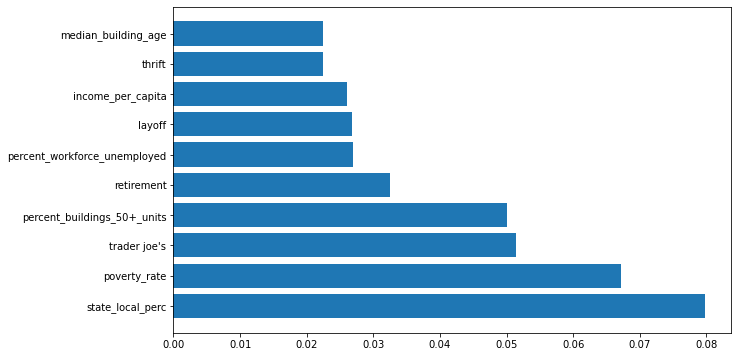

11226


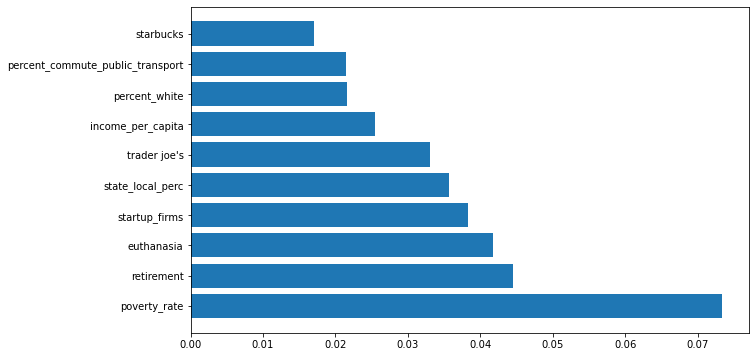

11228


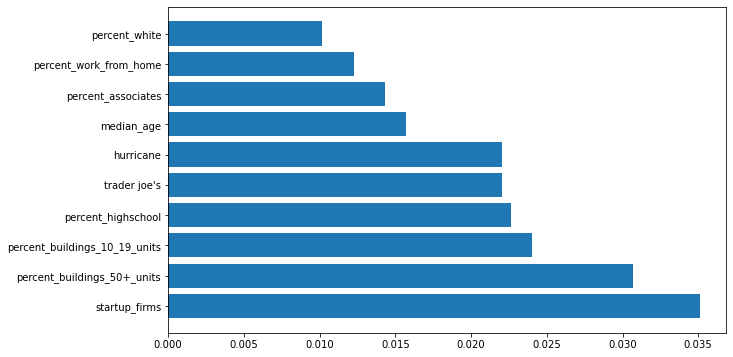

11229


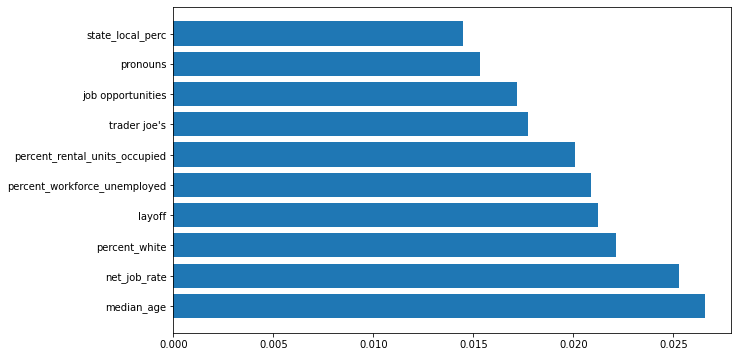

11230


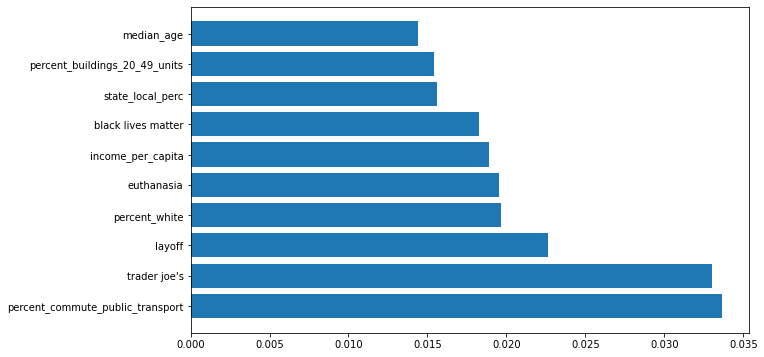

11231


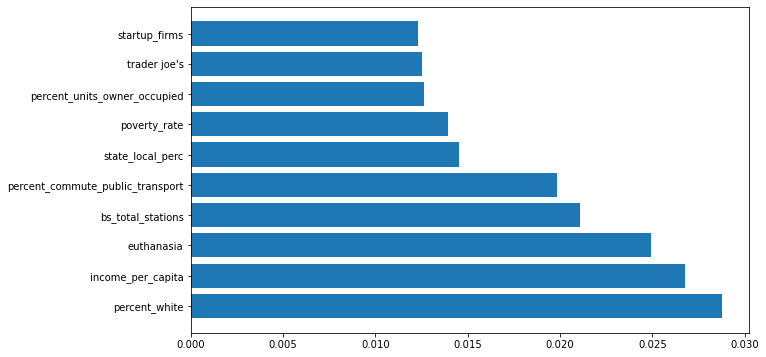

11232


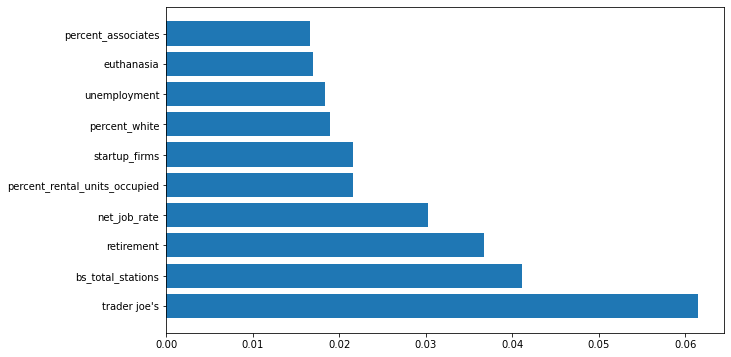

11233


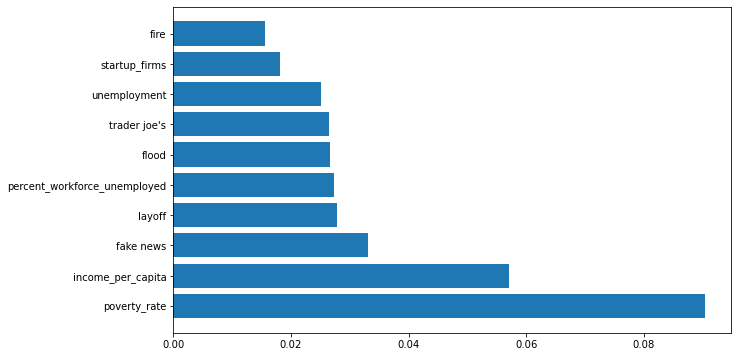

11234


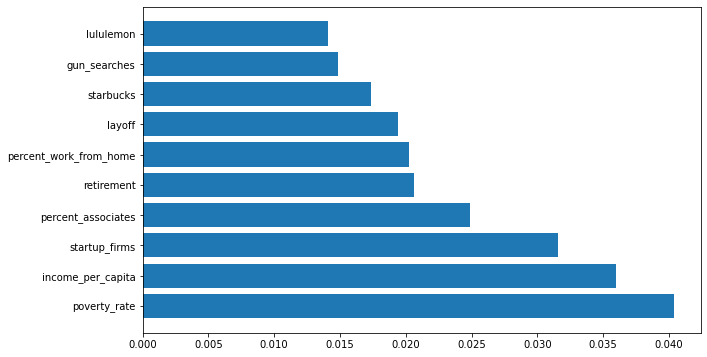

11235


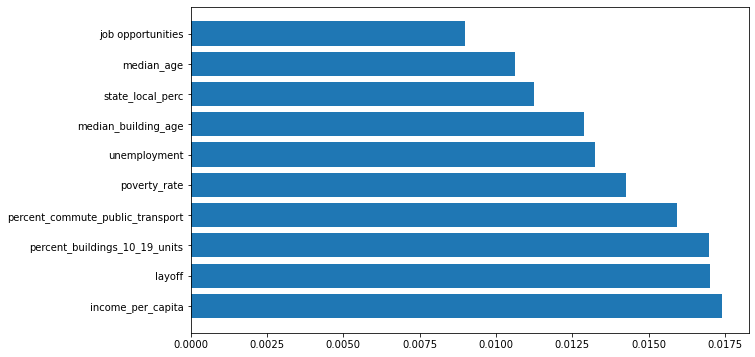

11236


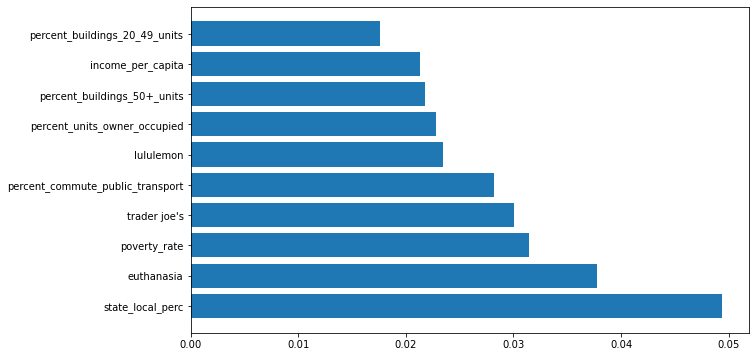

11237


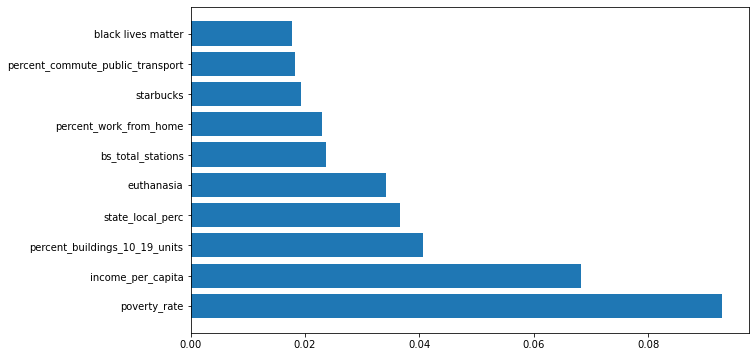

11238


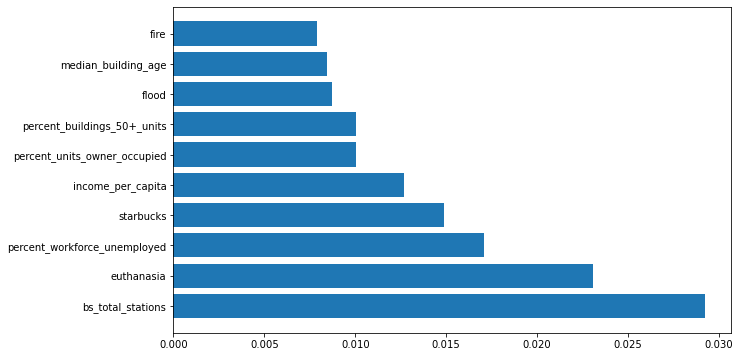

11354


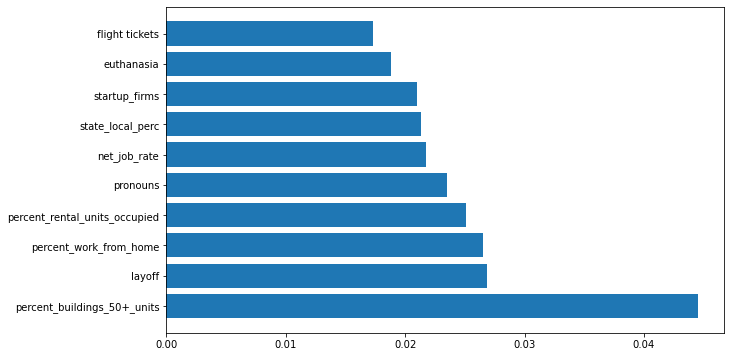

11355


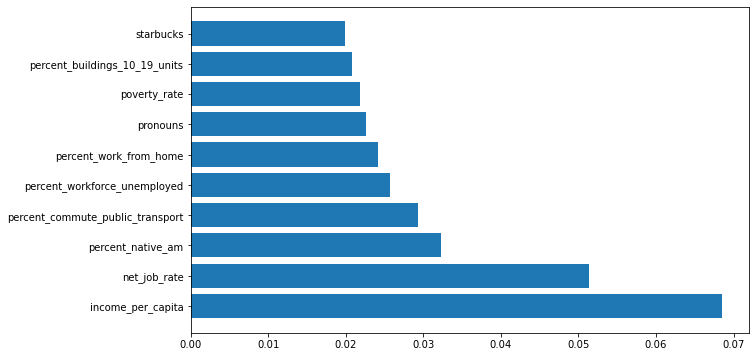

11356


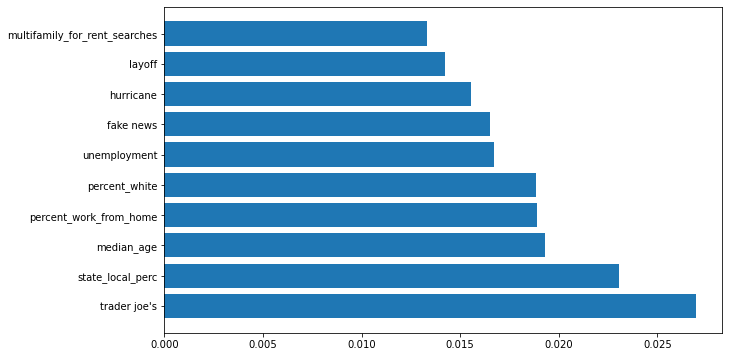

11357


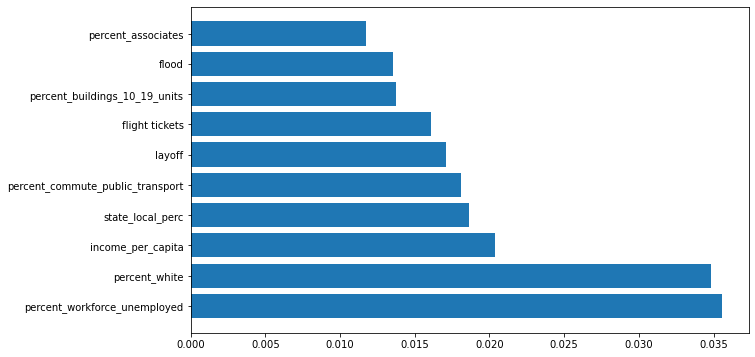

11358


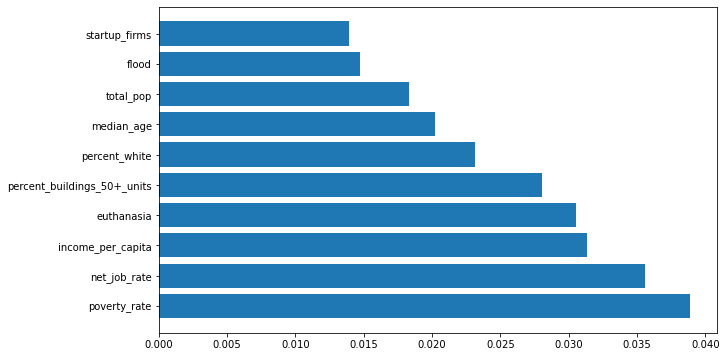

11360


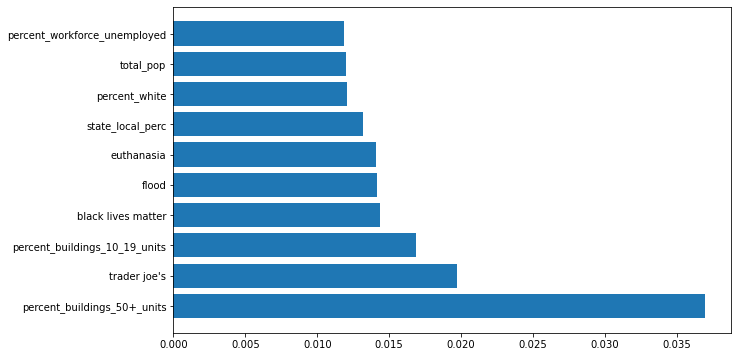

11361


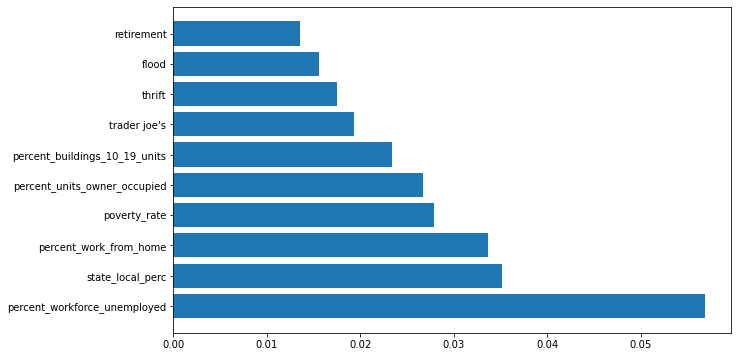

11364


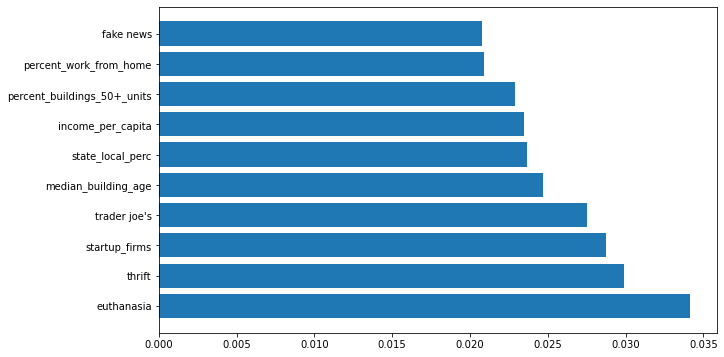

11365


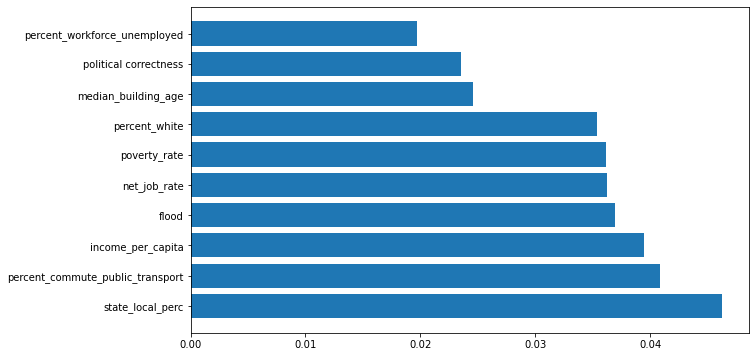

11366


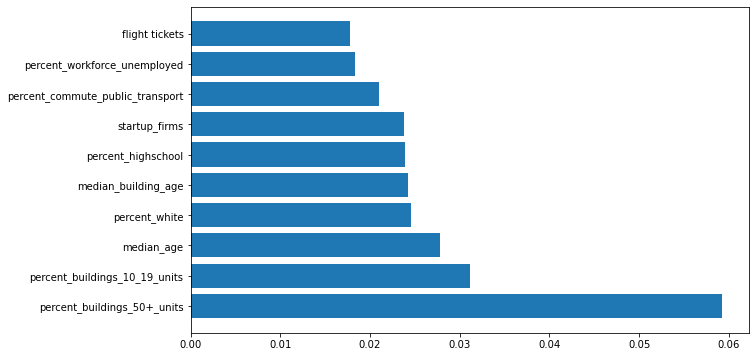

11367


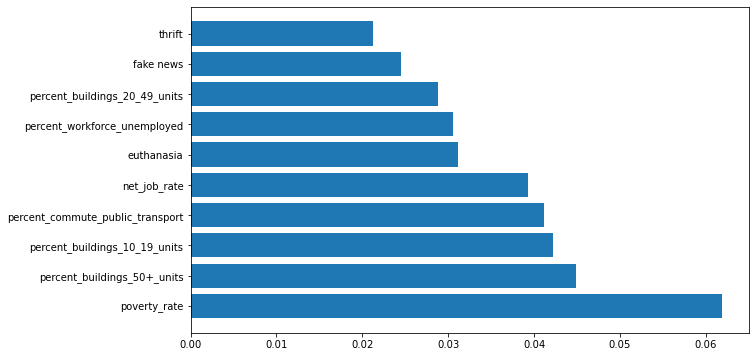

11368


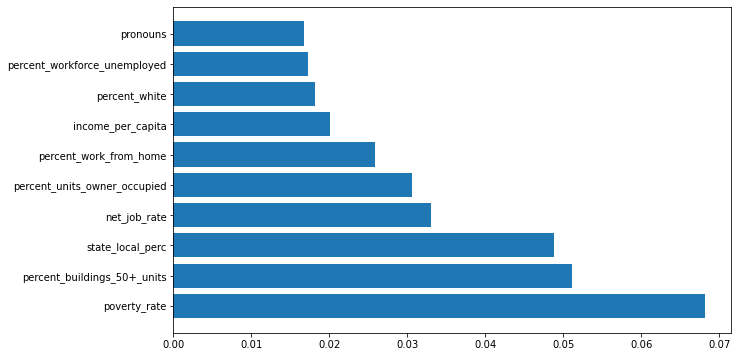

11369


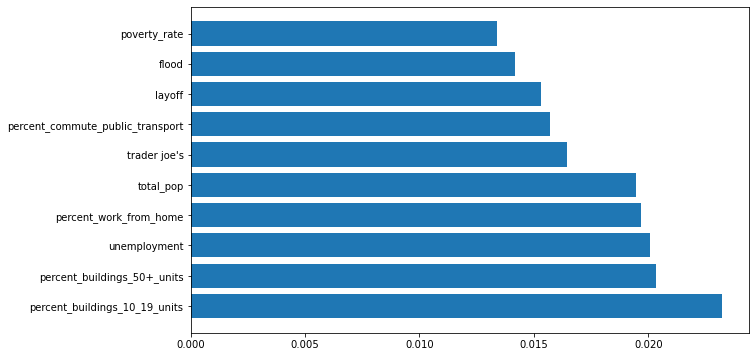

11370


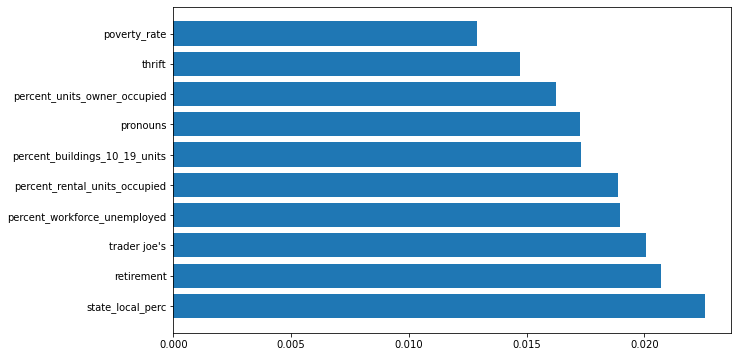

11372


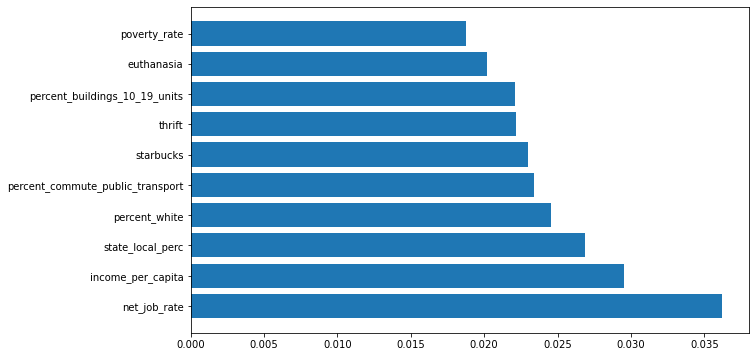

11373


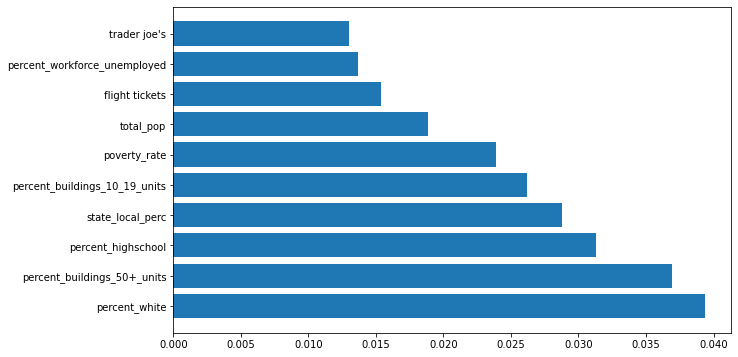

11374


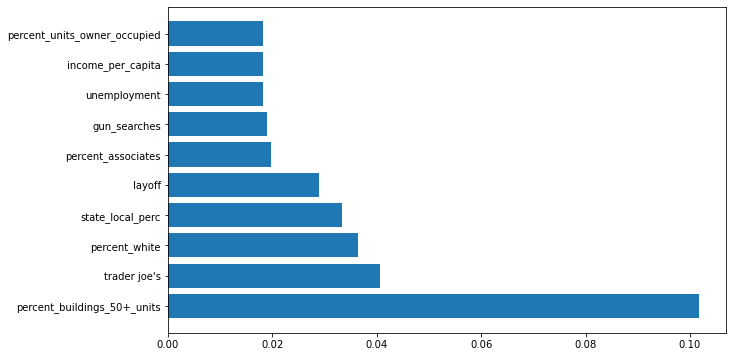

11375


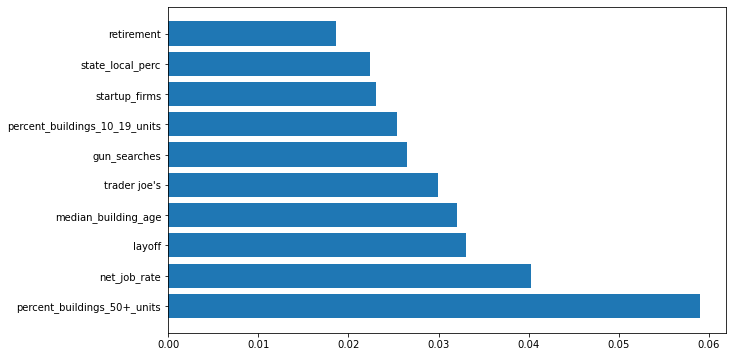

11377


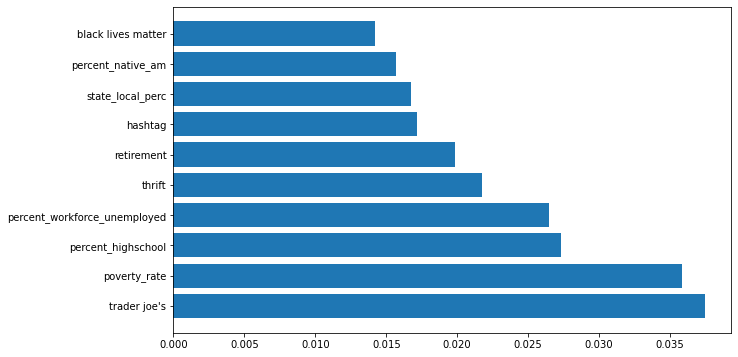

11378


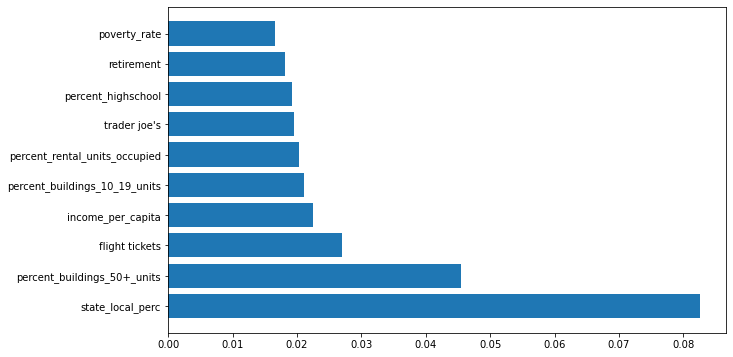

11379


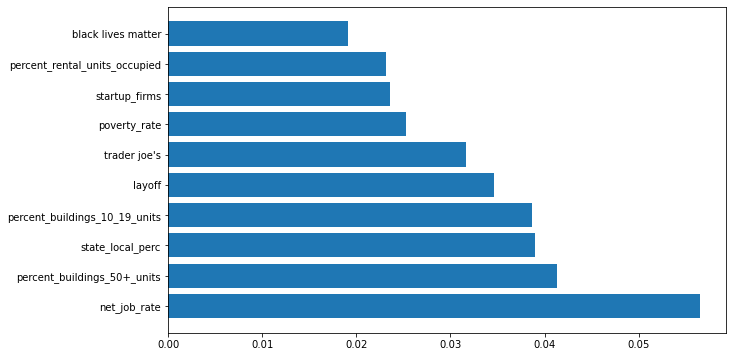

11385


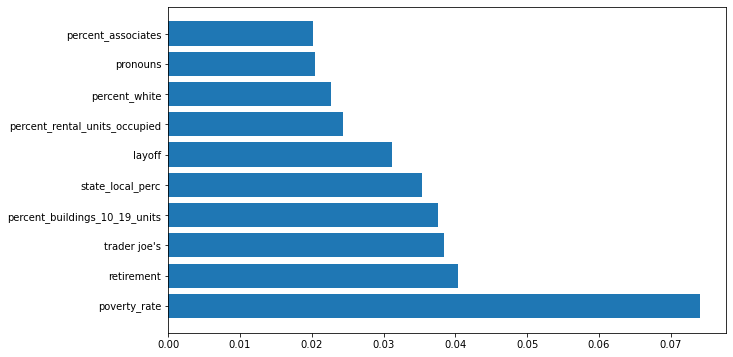

11412


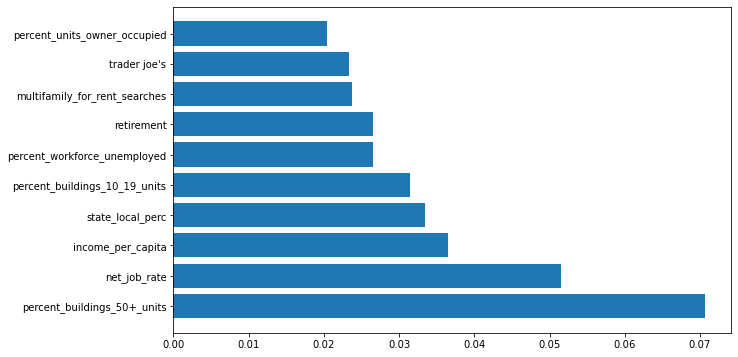

11413


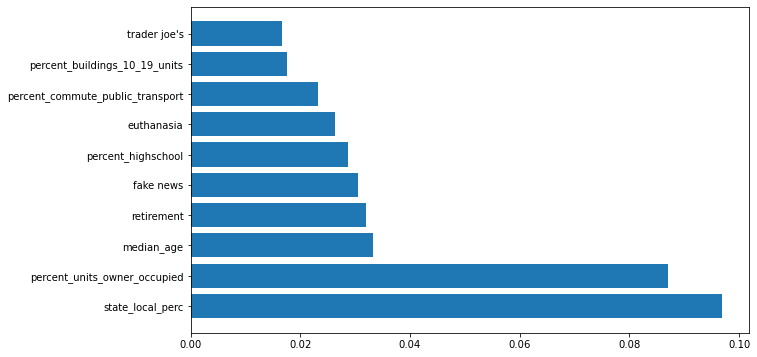

11414


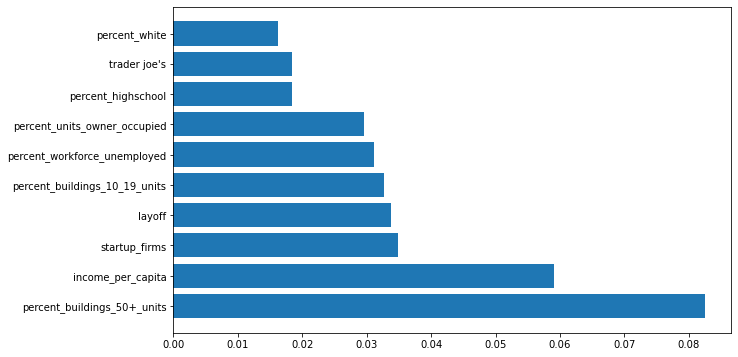

11415


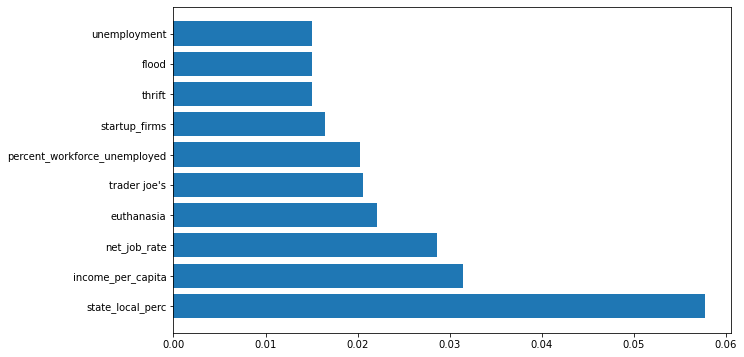

11416


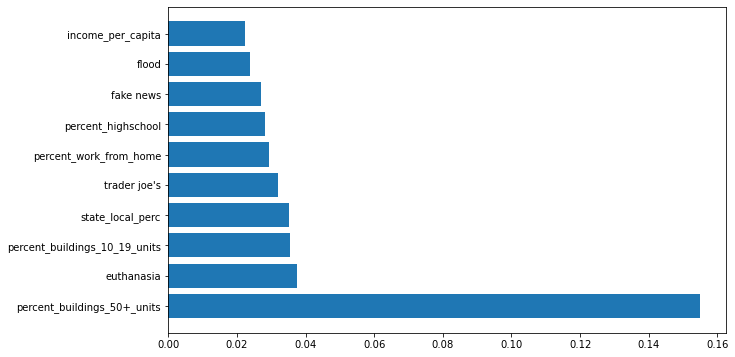

11417


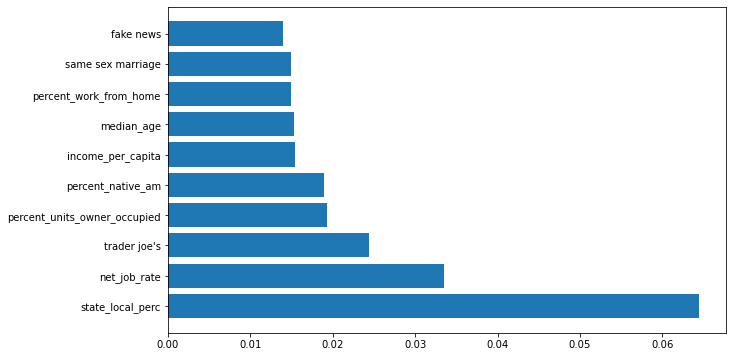

11418


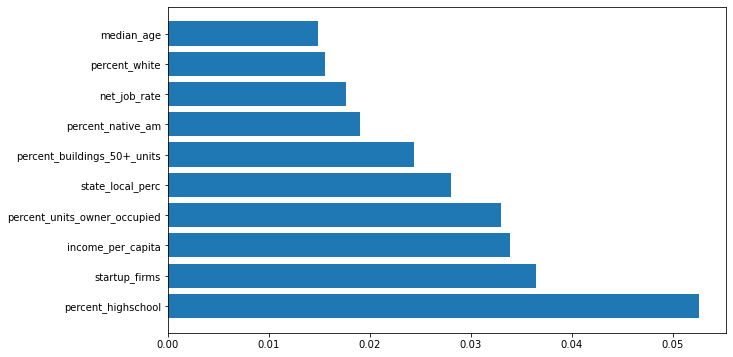

11419


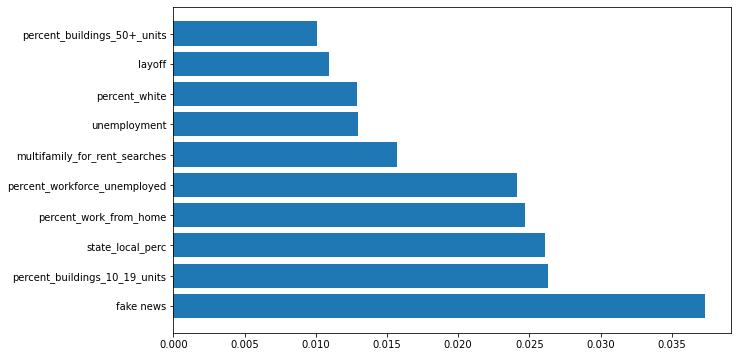

11420


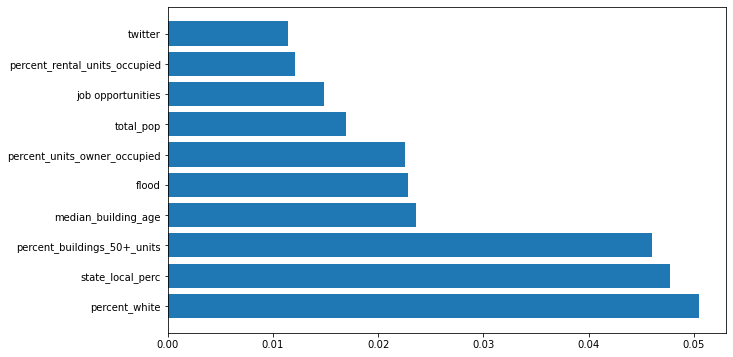

11421


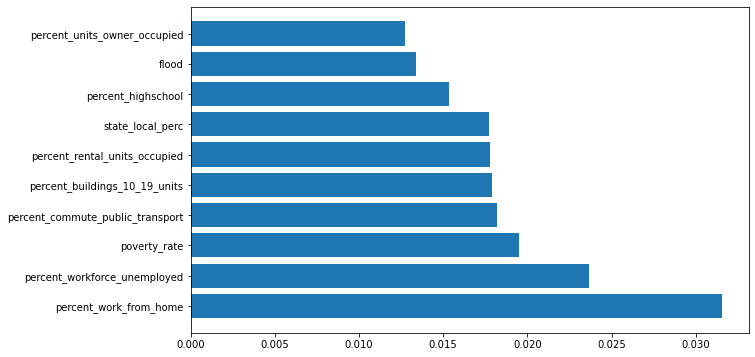

11422


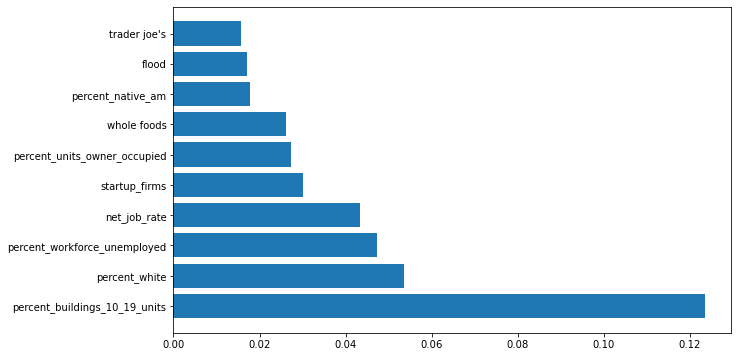

11423


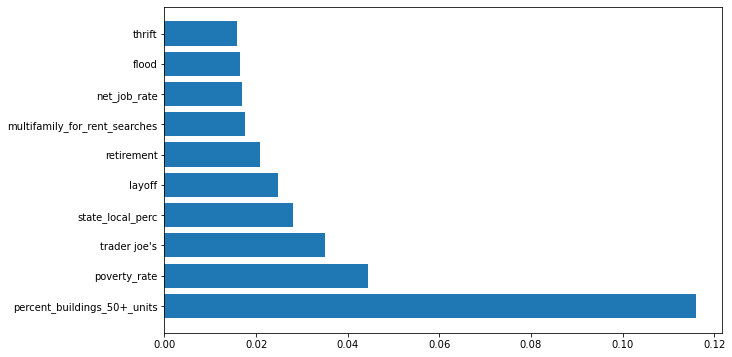

11426


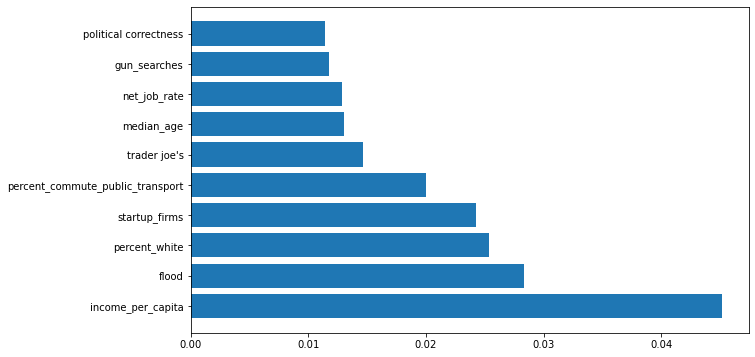

11427


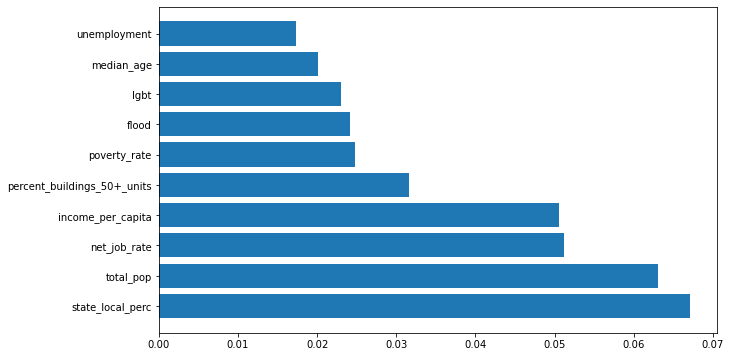

11428


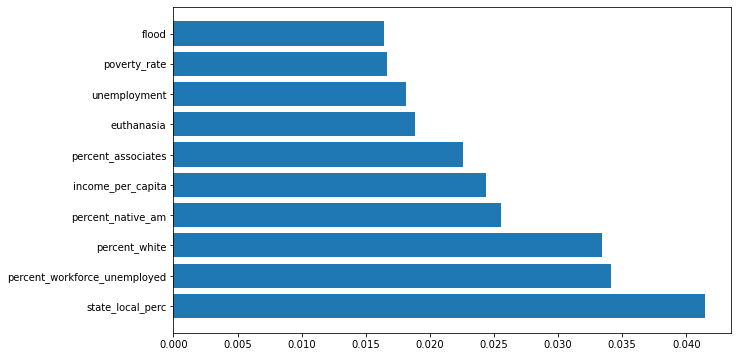

11429


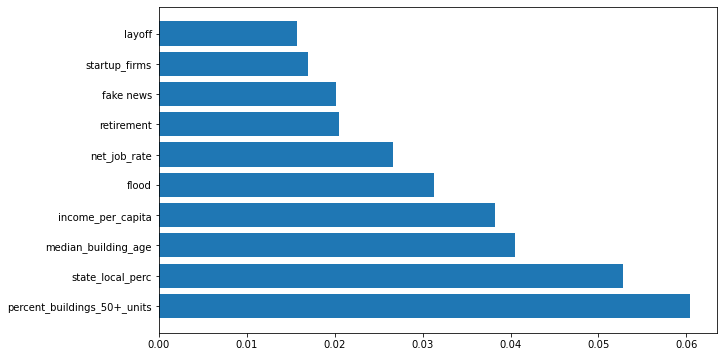

11432


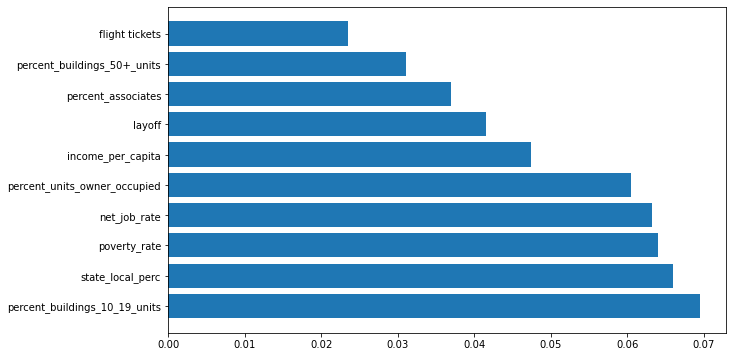

11433


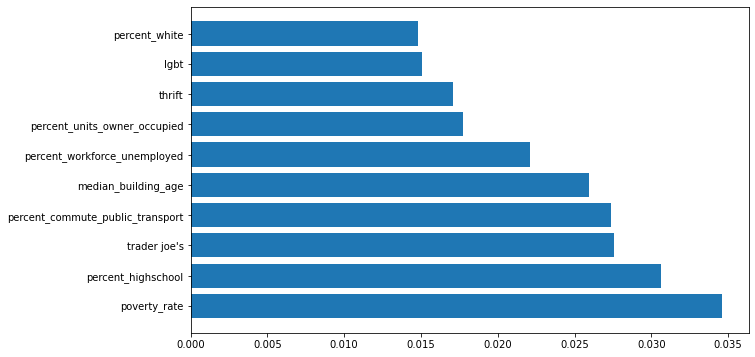

11434


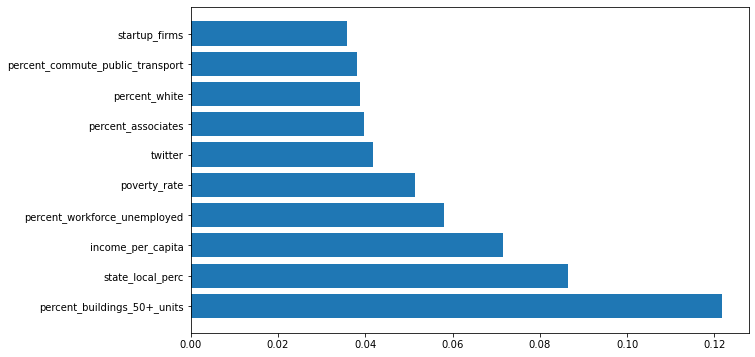

11435


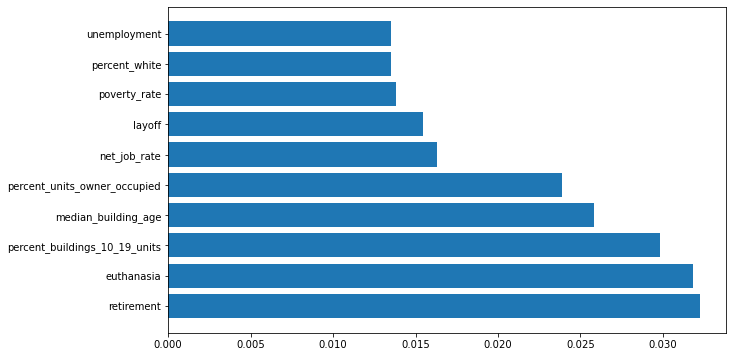

11436


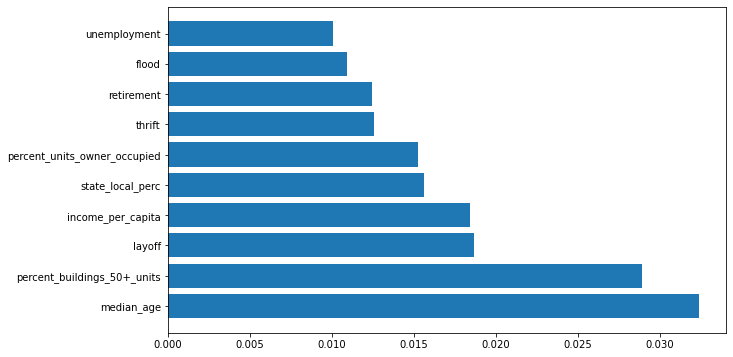

11542


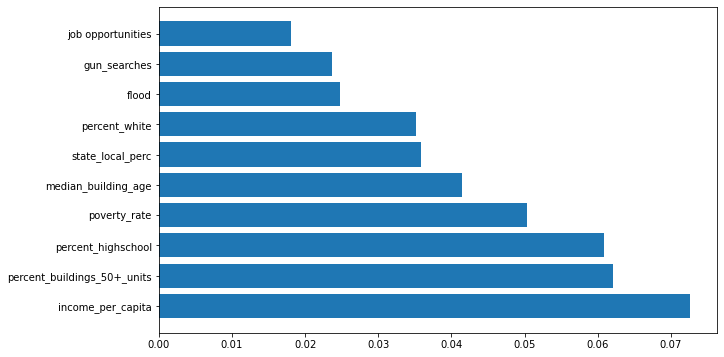

11550


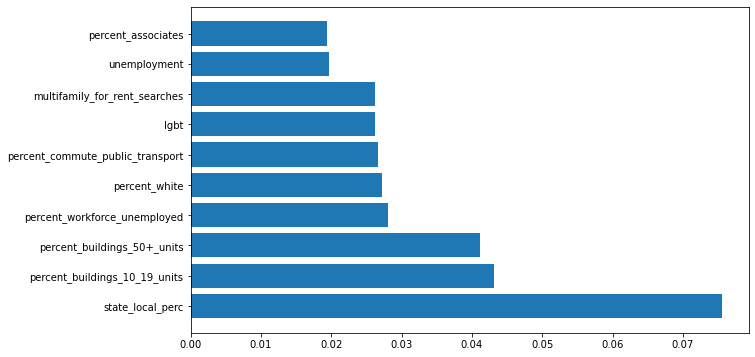

11561


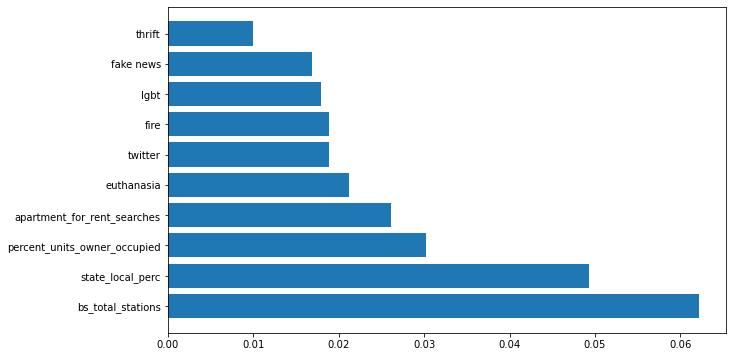

11563


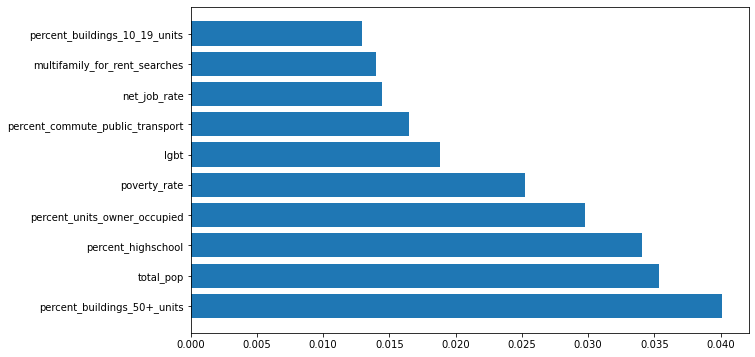

11580


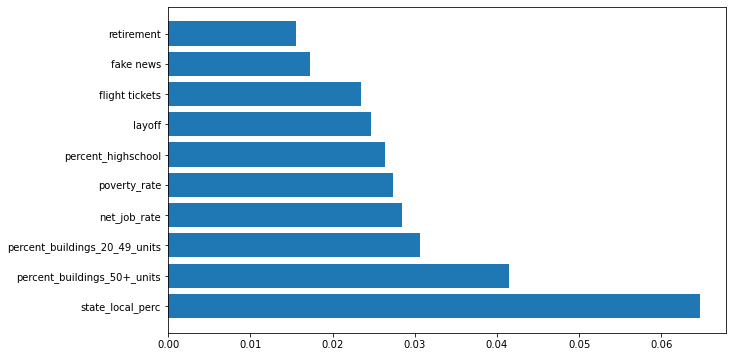

11590


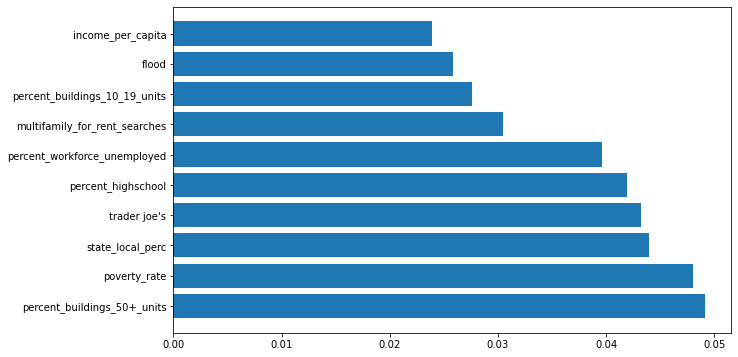

11691


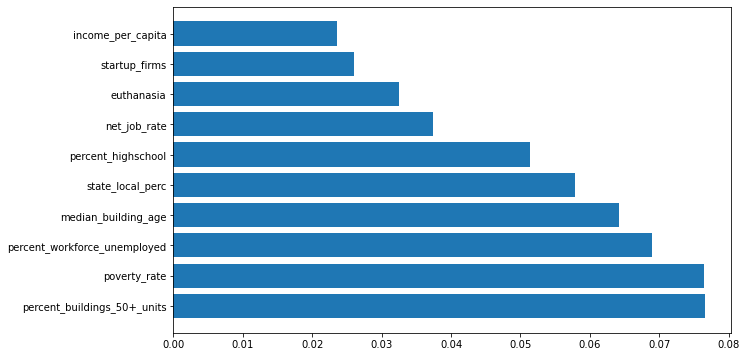

11692


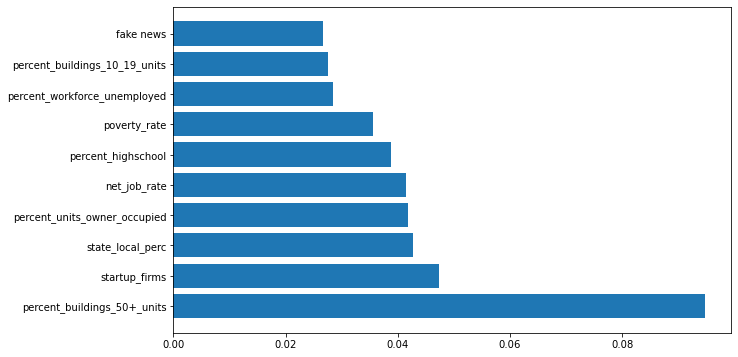

11694


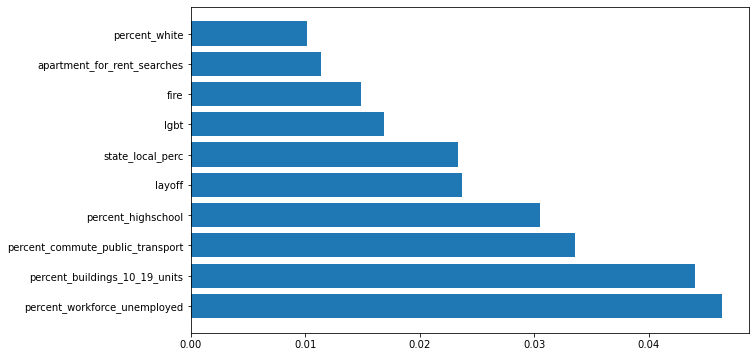

11758


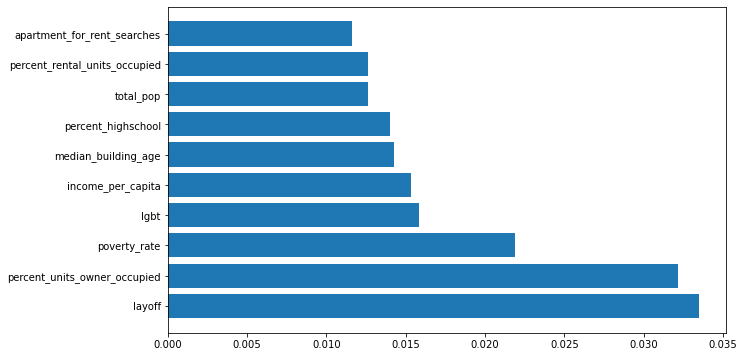

12047


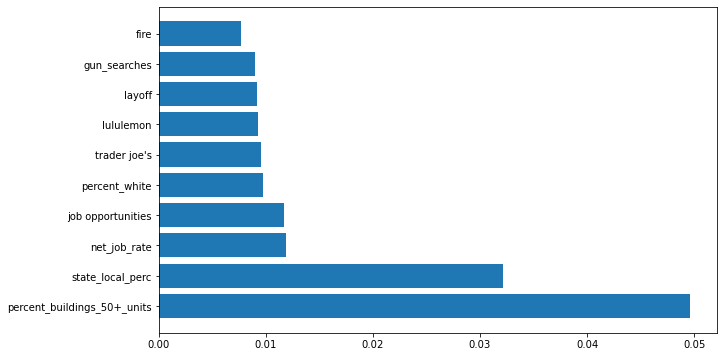

12180


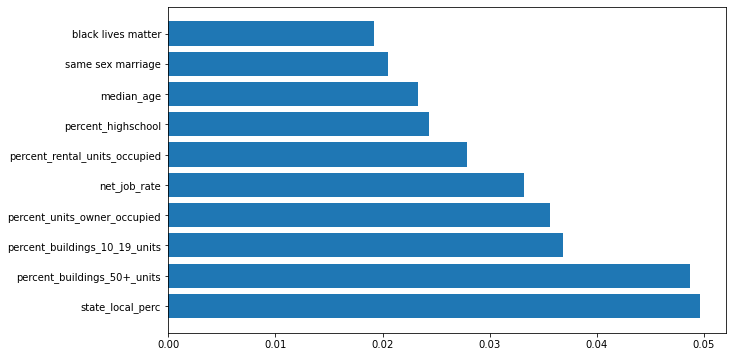

12182


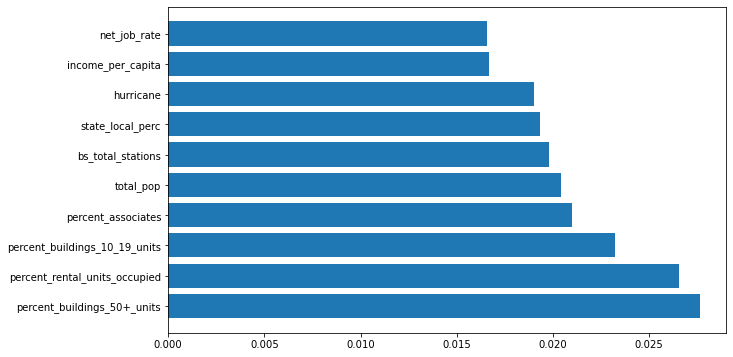

12189


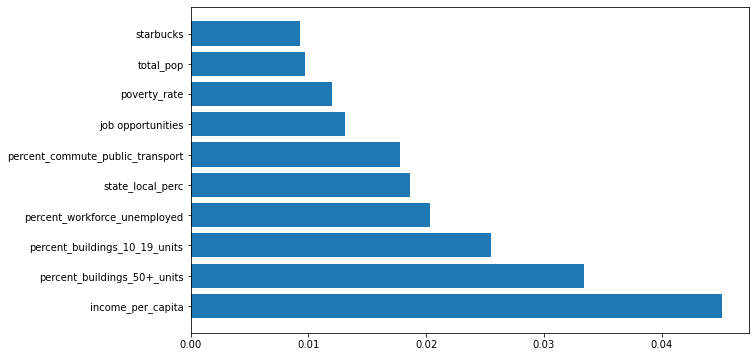

12202


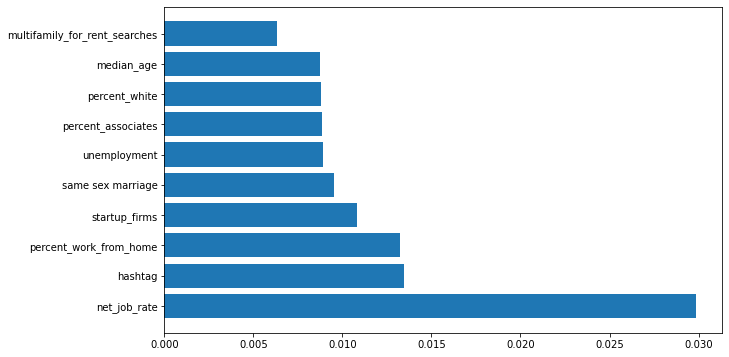

12203


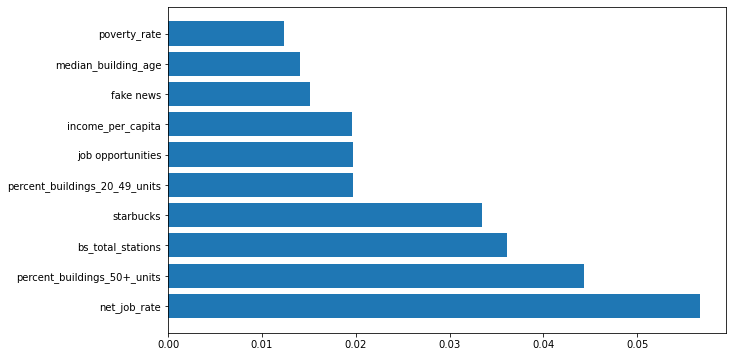

12206


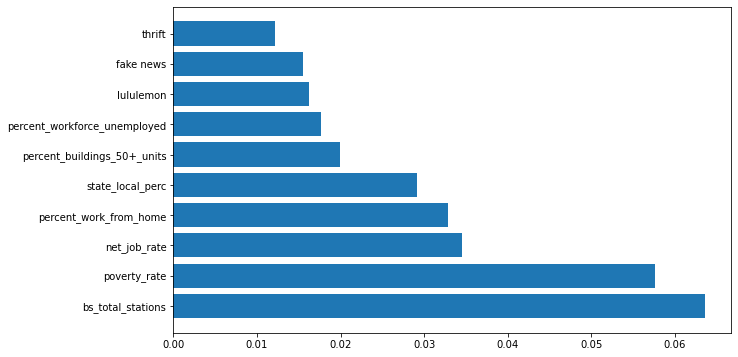

12208


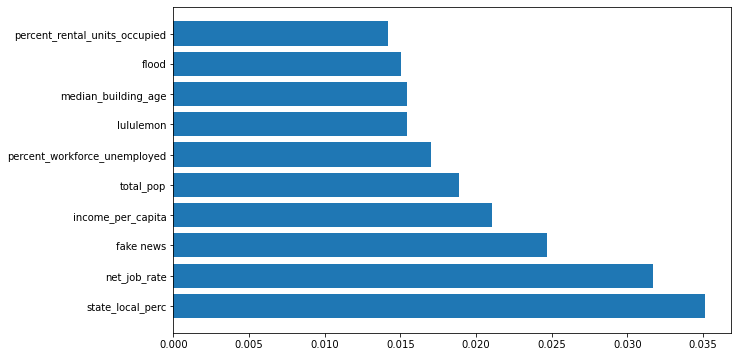

12209


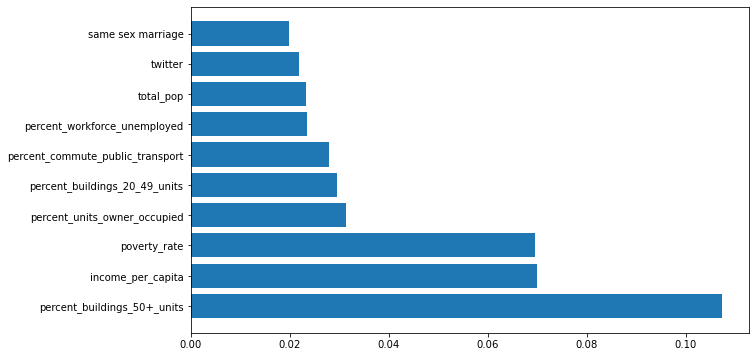

12210


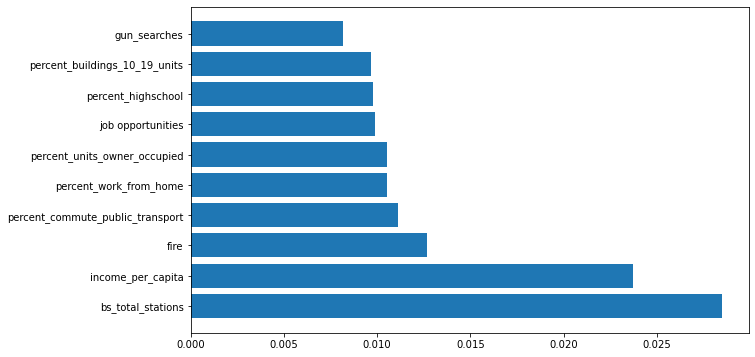

12303


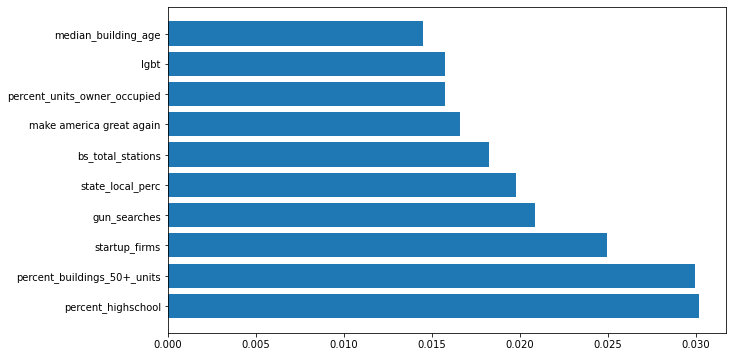

12304


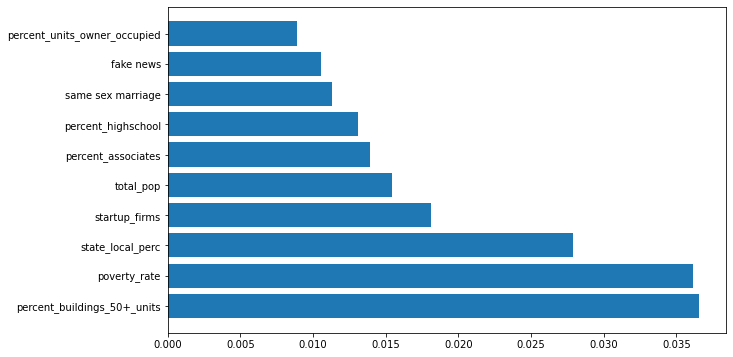

12306


KeyboardInterrupt: 

In [28]:
collection_importance = [];

for zip_num in multi_zip[START:END]:
    print(zip_num);
    scaler = MinMaxScaler();
    series = np.array(multi_data[multi_data.index == zip_num]);
    series_transformed = scaler.fit_transform(series);

    # Forecasting
    results, actual = NN_forecast(model, series_transformed, pure=False);

    # Compute MSE
    mse = mean_squared_error(actual[:-TEST_LENGTH], results[:-TEST_LENGTH])**0.5;
    # Usually we need to multiply by scaler.data_range_[0], but can ignore this.
    TRIALS = 1;
    PLOT_IMPORTANCE = True;
    
    perm_importance = [zip_num];
    for i in range(len(feature_name)):
        mse_feat = [];
        for _ in range(TRIALS):
            seq_perm = series_transformed.copy();
            seq_perm[:, i] = np.random.permutation(seq_perm[:,i])
            results, actual = NN_forecast(model, seq_perm, pure = False);
            mse_feat.append(mean_squared_error(actual[:-TEST_LENGTH], results[:-TEST_LENGTH])**0.5);

        perm_importance.append(sum(mse_feat)/TRIALS/mse - 1.0);
        # print("{}, {:.4f}".format(feature_name[i], sum(mse_feat)/TRIALS/mse - 1.0));

    importance = pd.DataFrame({"Feature": feature_name, "Importance": perm_importance[1:]});
    importance.sort_values("Importance", ascending = False, inplace = True);

    plt.figure(figsize=(10, 6));
    plt.barh(importance["Feature"][1:11], importance["Importance"][1:11]);
    plt.show();
    
    collection_importance.append(perm_importance);


In [38]:
collection_importance = collection_importance[:75]

In [39]:
len(collection_importance)

75

In [40]:
importance_df = pd.DataFrame(collection_importance, columns = ["zip"] + feature_name);
importance_df.to_csv('./Results in CSV files/Importance_{}_{}.csv'.format(START, END), index = False);

In [41]:
importance_df

,zip,zri,total_pop,percent_rental_units_occupied,percent_highschool,percent_work_from_home,percent_buildings_50+_units,median_building_age,median_age,income_per_capita,percent_native_am,percent_buildings_10_19_units,poverty_rate,percent_white,percent_commute_public_transport,percent_associates,percent_units_owner_occupied,percent_workforce_unemployed,percent_buildings_20_49_units,bs_total_stations,trader joe's,flood,gun_searches,pronouns,twitter,lululemon,retirement,same sex marriage,hurricane,political correctness,job opportunities,unemployment,layoff,wildfire,hashtag,fake news,multifamily_for_rent_searches,thrift,make america great again,flight tickets,black lives matter,lgbt,whole foods,fire,apartment_for_rent_searches,places to go,starbucks,getaway,euthanasia,net_job_rate,startup_firms,state_local_perc
0,11225,4.294343,-0.000804,-0.003464,-0.013398,-0.017215,0.050058,0.022382,0.003114,0.026054,0.001093,-0.020020,0.067127,0.013172,-0.007124,0.011527,0.001455,0.026946,0.010254,0.012897,0.051469,-0.010014,-0.001528,-0.008921,-0.006296,-0.005636,0.032479,-0.017794,0.019226,0.006323,0.006887,0.010878,0.026851,0.000446,0.004163,0.000133,0.002460,0.022508,0.004768,0.010034,0.005704,-0.020374,-0.005203,-0.003580,-0.029311,-0.007985,0.016126,-0.001131,-0.004511,0.012032,0.000630,0.079759
1,11226,10.229007,0.011731,-0.024204,-0.006470,-0.031283,0.011340,-0.007049,0.006269,0.025447,0.003942,0.014101,0.073382,0.021613,0.021475,-0.017166,-0.009684,0.005347,0.002596,0.000000,0.033012,0.015635,0.011984,-0.010436,-0.002658,-0.002843,0.044471,-0.017306,-0.006603,0.004905,0.006158,0.008041,0.014780,-0.008107,0.002659,0.009840,0.007337,-0.005106,0.002400,0.013366,0.005762,-0.014436,0.007344,-0.003096,-0.026419,0.002989,0.017041,0.010332,0.041821,-0.020626,0.038359,0.035675
2,11228,5.338377,-0.022884,-0.014805,0.022608,0.012283,0.030660,-0.003037,0.015671,0.000808,-0.006549,0.024044,0.000334,0.010136,-0.000231,0.014302,-0.022306,0.007022,0.008291,0.000000,0.022050,-0.001236,0.006785,-0.019715,-0.024103,0.005907,0.006615,-0.009127,0.022021,-0.004495,0.007336,0.009833,0.002849,-0.001413,-0.001701,0.001682,0.000984,0.005791,-0.018032,-0.012444,0.004157,-0.015469,-0.000708,-0.001242,-0.010468,-0.003097,0.001908,0.004934,-0.017705,0.007643,0.035092,-0.007485
3,11229,6.354803,-0.024771,0.020099,-0.000653,-0.023711,-0.000663,-0.010838,0.026570,0.002477,-0.000057,-0.024369,-0.014522,0.022123,0.000373,0.008829,-0.000575,0.020886,-0.009457,0.000000,0.017730,-0.006718,0.003386,0.015350,-0.007956,-0.003140,-0.006782,-0.001072,0.005037,-0.011222,0.017181,0.009769,0.021230,-0.000296,0.011635,-0.000854,-0.001993,0.011636,-0.002901,0.013267,-0.001149,-0.012471,-0.009818,0.000629,-0.008668,0.005190,0.001827,0.003115,-0.002829,0.025293,-0.010565,0.014499
4,11230,9.913295,-0.005661,-0.013249,-0.006644,0.007074,0.004838,-0.003451,0.014395,0.018868,-0.010430,-0.007328,-0.034028,0.019651,0.033651,0.002643,0.012795,-0.003289,0.015389,0.000000,0.033016,0.008608,0.009146,-0.017103,-0.031169,-0.005996,0.014292,-0.012903,0.002723,0.009670,-0.001107,-0.001339,0.022609,0.000000,-0.001310,0.005724,-0.009159,0.005505,-0.005114,0.001303,0.018282,-0.014036,-0.003079,-0.004906,-0.027737,-0.006220,-0.002336,0.007647,0.019525,0.007393,0.004076,0.015591
5,11231,5.361693,-0.007007,0.001204,0.002138,0.006801,-0.008560,-0.003331,0.005010,0.026781,-0.008298,-0.001423,0.013927,0.028762,0.019852,0.004541,0.012643,0.003811,0.001469,0.021088,0.012523,-0.009190,-0.005036,0.003580,-0.024120,-0.000860,-0.005174,-0.002251,0.000039,0.000998,-0.003563,0.009323,0.000592,-0.004090,-0.002410,0.001114,0.002020,0.006411,-0.002458,0.003436,0.002946,-0.016327,0.002194,-0.010431,0.005233,0.002241,0.008788,-0.009814,0.024897,0.011223,0.012295,0.014544
6,11232,8.315370,-0.026074,0.021567,-0.004298,-0.021985,-0.033395,-0.010185,-0.007667,-0.007319,0.002247,-0.006835,0.011578,0.018961,-0.024022,0.016565,0.010320,-0.030132,0.004752,0.041103,0.061455,-0.007796,0.006202,0.002369,-0.019020,-0.007749,0.036687